## Progetto AI: Smart Home Energy Saver
l'idea di base reare un sistema che decida probabilisticamente se accendere o meno l'irrigazione del giardino e le luci esterne, basandosi su vari fattori incerti.
Le Variabili (Nodi della Rete):

    -Meteo (Pioggia): Piove o c'è il sole? (Nodo radice).

    -Stagione: Quale stagione è? Inverno, Primavera, Estate, Autunno? (Nodo radice).

    -Umidità Terreno: È umido o secco? (Dipende da Meteo e Stagione).

    -Previsioni Meteo: Cosa dice l'app meteo? (Dipende da Meteo - nota: le previsioni non sono sempre esatte!).

    -Irrigatore: Si deve accendere? (Dipende da Umidità Terreno).

Librerie Usate:
- pgmpy
- networkx 
- matplotlib


In [46]:

%pip install pgmpy networkx matplotlib

Note: you may need to restart the kernel to use updated packages.


### Importazione Librerie

Nella cella successiva vengono importate le librerie necessarie per costruire e visualizzare la rete bayesiana:

- **`pgmpy.models`**: Contiene `BayesianNetwork` e `DiscreteBayesianNetwork` per definire la struttura della rete bayesiana (nodi e archi)
- **`pgmpy.factors.discrete.TabularCPD`**: Permette di definire le Tabelle di Probabilità Condizionata (CPT) per ogni nodo
- **`networkx`**: Libreria per la manipolazione e analisi di grafi, usata per visualizzare la struttura della rete
- **`matplotlib.pyplot`**: Libreria per la creazione di grafici e visualizzazioni

In [47]:
from pgmpy.models import BayesianNetwork, DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt


### Definizione della Rete Bayesiana

Nella cella successiva viene costruita la rete bayesiana completa:

1. **Struttura del grafo**: Definizione dei nodi e degli archi che rappresentano le relazioni causali tra le variabili
2. **Tabelle di Probabilità Condizionata (CPT)**: Per ogni variabile viene definita la distribuzione di probabilità:
    - **Stagione**: Probabilità a priori (25% per ogni stagione)
    - **Pioggia**: Dipende dalla stagione (alta in Inverno, media in Primavera/Autunno, bassa in Estate)
    - **Previsioni Meteo**: Dipende dalla pioggia reale (con margine di errore)
    - **Umidità Terreno**: Dipende da pioggia e stagione
    - **Irrigatore**: Dipende dall'umidità del terreno
3. **Validazione del modello**: Verifica che tutte le CPT siano correttamente definite

In [ ]:
# Definizione della struttura della rete bayesiana
bn_model = DiscreteBayesianNetwork([
    ('Stagione', 'Pioggia'),
    ('Stagione', 'Umidita_Terreno'),
    ('Pioggia', 'Umidita_Terreno'),
    ('Pioggia', 'Previsioni_Meteo'),
    ('Umidita_Terreno', 'Irrigatore')
])

# CPT per Stagione (nodo radice): 4 stagioni equiprobabili
cpd_stagione = TabularCPD(
    variable='Stagione',
    variable_card=4,
    values=[[0.25], [0.25], [0.25], [0.25]],
    state_names={'Stagione': ['Inverno', 'Primavera', 'Estate', 'Autunno']}
)

# CPT per Pioggia (dipende da Stagione): 0=No, 1=Sì
cpd_pioggia = TabularCPD(
    variable='Pioggia',
    variable_card=2,
    values=[
        [0.2, 0.4, 0.85, 0.35],  # P(Pioggia=No | Stagione=Inverno, Primavera, Estate, Autunno)
        [0.8, 0.6, 0.15, 0.65]   # P(Pioggia=Sì | Stagione=Inverno, Primavera, Estate, Autunno)
    ],
    evidence=['Stagione'],
    evidence_card=[4],
    state_names={'Pioggia': ['No', 'Sì'], 'Stagione': ['Inverno', 'Primavera', 'Estate', 'Autunno']}
)

# CPT per Previsioni_Meteo (dipende da Pioggia): 0=Sole, 1=Pioggia
cpd_previsioni = TabularCPD(
    variable='Previsioni_Meteo',
    variable_card=2,
    values=[
        [0.8, 0.1],  # P(Previsioni=Sole | Pioggia)
        [0.2, 0.9]   # P(Previsioni=Pioggia | Pioggia)
    ],
    evidence=['Pioggia'],
    evidence_card=[2],
    state_names={'Previsioni_Meteo': ['Sole', 'Pioggia'], 'Pioggia': ['No', 'Sì']}
)

# CPT per Umidita_Terreno (dipende da Pioggia e Stagione): 0=Secco, 1=Umido
# LOGICA: Se piove → terreno è UMIDO (99%). Se non piove → dipende dalla stagione.
cpd_umidita = TabularCPD(
    variable='Umidita_Terreno',
    variable_card=2,
    values=[
        # Pioggia:    No,   No,   No,   No,   Sì,   Sì,   Sì,   Sì
        # Stagione: Inv, Prim, Est, Aut, Inv, Prim, Est, Aut
        # Senza pioggia: dipende stagione. Con pioggia: sempre 99% umido
        [0.4, 0.5, 0.98, 0.7, 0.01, 0.01, 0.01, 0.01],  # P(Secco)
        [0.6, 0.5, 0.02, 0.3, 0.99, 0.99, 0.99, 0.99]   # P(Umido)
    ],
    evidence=['Pioggia', 'Stagione'],
    evidence_card=[2, 4],
    state_names={'Umidita_Terreno': ['Secco', 'Umido'], 'Pioggia': ['No', 'Sì'], 'Stagione': ['Inverno', 'Primavera', 'Estate', 'Autunno']}
)

# CPT per Irrigatore (dipende da Umidita_Terreno): 0=Spento, 1=Acceso
cpd_irrigatore = TabularCPD(
    variable='Irrigatore',
    variable_card=2,
    values=[
        [0.1, 0.9],  # P(Spento | Umidità)
        [0.9, 0.1]   # P(Acceso | Umidità)
    ],
    evidence=['Umidita_Terreno'],
    evidence_card=[2],
    state_names={'Irrigatore': ['Spento', 'Acceso'], 'Umidita_Terreno': ['Secco', 'Umido']}
)

# Aggiunta delle CPT al modello
bn_model.add_cpds(cpd_stagione, cpd_pioggia, cpd_previsioni, cpd_umidita, cpd_irrigatore)

# Verifica della correttezza del modello
print("Modello valido:", bn_model.check_model())
print("\nCPT definite:")
for cpd in bn_model.get_cpds():
    print(f"\n{cpd}")


Modello valido: True

CPT definite:

+---------------------+------+
| Stagione(Inverno)   | 0.25 |
+---------------------+------+
| Stagione(Primavera) | 0.25 |
+---------------------+------+
| Stagione(Estate)    | 0.25 |
+---------------------+------+
| Stagione(Autunno)   | 0.25 |
+---------------------+------+

+-------------+-------------------+-----+-------------------+
| Stagione    | Stagione(Inverno) | ... | Stagione(Autunno) |
+-------------+-------------------+-----+-------------------+
| Pioggia(No) | 0.2               | ... | 0.35              |
+-------------+-------------------+-----+-------------------+
| Pioggia(Sì) | 0.8               | ... | 0.65              |
+-------------+-------------------+-----+-------------------+

+---------------------------+-------------+-------------+
| Pioggia                   | Pioggia(No) | Pioggia(Sì) |
+---------------------------+-------------+-------------+
| Previsioni_Meteo(Sole)    | 0.8         | 0.1         |
+---------------

In [49]:
import pandas as pd
from pgmpy.sampling import BayesianModelSampling

# Generazione del dataset simulato - 10.000 istanze
print("Generazione dataset simulato dal modello bayesiano...")
sampler = BayesianModelSampling(bn_model)
dataset = sampler.forward_sample(size=10000, seed=42)

print(f"Dataset generato: {dataset.shape[0]} istanze, {dataset.shape[1]} variabili\n")
print("Prime 10 righe del dataset:")
print(dataset.head(10))

print("\n" + "="*60)
print("STATISTICHE DESCRITTIVE DEL DATASET")
print("="*60)

# Analisi distribuzione per ogni variabile
for col in dataset.columns:
    print(f"\n{col}:")
    value_counts = dataset[col].value_counts().sort_index()
    for idx, (val, count) in enumerate(value_counts.items()):
        percentage = (count / len(dataset)) * 100
        print(f"  {val}: {count:5d} ({percentage:6.2f}%)")

# Correlazioni tra variabili
print("\n" + "="*60)
print("FREQUENZE CONGIUNTE (Campionato vs Teorico)")
print("="*60)

# Esempio: P(Pioggia, Stagione)
pioggia_stagione = pd.crosstab(dataset['Pioggia'], dataset['Stagione'], normalize='columns')
print("\nP(Pioggia | Stagione) - Frequenze nel dataset:")
print(pioggia_stagione)

Generazione dataset simulato dal modello bayesiano...


Generating for node: Irrigatore: 100%|██████████| 5/5 [00:00<00:00, 210.27it/s]

Dataset generato: 10000 istanze, 5 variabili

Prime 10 righe del dataset:
    Stagione Pioggia Umidita_Terreno Previsioni_Meteo Irrigatore
0  Primavera      Sì           Umido          Pioggia     Spento
1    Autunno      Sì           Umido          Pioggia     Spento
2     Estate      Sì           Umido          Pioggia     Spento
3     Estate      Sì           Umido          Pioggia     Spento
4    Inverno      Sì           Umido          Pioggia     Spento
5    Inverno      Sì           Umido          Pioggia     Acceso
6    Inverno      No           Umido             Sole     Spento
7    Autunno      Sì           Umido          Pioggia     Acceso
8     Estate      No           Secco             Sole     Acceso
9     Estate      Sì           Umido          Pioggia     Spento

STATISTICHE DESCRITTIVE DEL DATASET

Stagione:
  Autunno:  2413 ( 24.13%)
  Estate:  2511 ( 25.11%)
  Inverno:  2547 ( 25.47%)
  Primavera:  2529 ( 25.29%)

Pioggia:
  No:  4451 ( 44.51%)
  Sì:  5549 ( 55.49%)


In [50]:
import os

# Salvataggio del dataset in CSV
output_dir = r'C:\Users\nikec\Desktop\magistrale\Intelligenza artificiale\Progetto AI'
csv_filename = 'dataset_smart_home_10000.csv'
csv_path = os.path.join(output_dir, csv_filename)

# Salva il dataset
dataset.to_csv(csv_path, index=False)
print(f"✓ Dataset salvato con successo!")
print(f"  Percorso: {csv_path}")
print(f"  Dimensioni file: {os.path.getsize(csv_path) / 1024:.2f} KB")
print(f"  Righe: {len(dataset)}")
print(f"  Colonne: {len(dataset.columns)}")

# Verifica il file salvato
print(f"\n✓ Verifica - Prime 5 righe dal file CSV:")
dataset_verificato = pd.read_csv(csv_path)
print(dataset_verificato.head())

print(f"\n✓ Informazioni del file CSV:")
print(f"  Dimensioni: {dataset_verificato.shape}")
print(f"  Colonne: {list(dataset_verificato.columns)}")
print(f"  Tipi di dati:\n{dataset_verificato.dtypes}")

✓ Dataset salvato con successo!
  Percorso: C:\Users\nikec\Desktop\magistrale\Intelligenza artificiale\Progetto AI\dataset_smart_home_10000.csv
  Dimensioni file: 318.17 KB
  Righe: 10000
  Colonne: 5

✓ Verifica - Prime 5 righe dal file CSV:
    Stagione Pioggia Umidita_Terreno Previsioni_Meteo Irrigatore
0  Primavera      Sì           Umido          Pioggia     Spento
1    Autunno      Sì           Umido          Pioggia     Spento
2     Estate      Sì           Umido          Pioggia     Spento
3     Estate      Sì           Umido          Pioggia     Spento
4    Inverno      Sì           Umido          Pioggia     Spento

✓ Informazioni del file CSV:
  Dimensioni: (10000, 5)
  Colonne: ['Stagione', 'Pioggia', 'Umidita_Terreno', 'Previsioni_Meteo', 'Irrigatore']
  Tipi di dati:
Stagione            object
Pioggia             object
Umidita_Terreno     object
Previsioni_Meteo    object
Irrigatore          object
dtype: object


### Generazione Dataset Simulato

Generiamo un dataset realistico con 10.000 istanze campionate dalla rete bayesiana. Questo dataset sarà usato per:
- Stimare le probabilità empiriche dal dati reali
- Validare il modello su un grande volume di dati
- Analizzare pattern e correlazioni nel mondo reale


### Visualizzazione della Rete Bayesiana

La cella successiva genera una rappresentazione grafica della rete bayesiana costruita, mostrando:

- **Nodi**: Rappresentano le variabili del modello, colorati in base al loro ruolo:
    -  **Rosso**: Nodi radice (cause primarie)
    -  **Azzurro**: Osservazioni (dati rilevati)
    -  **Verde**: Stati intermedi
    -  **Giallo**: Decisioni finali

- **Archi**: Indicano le relazioni di dipendenza causale tra le variabili

- **Layout**: Disposizione gerarchica che evidenzia il flusso causale dall'alto (cause) verso il basso (effetti)

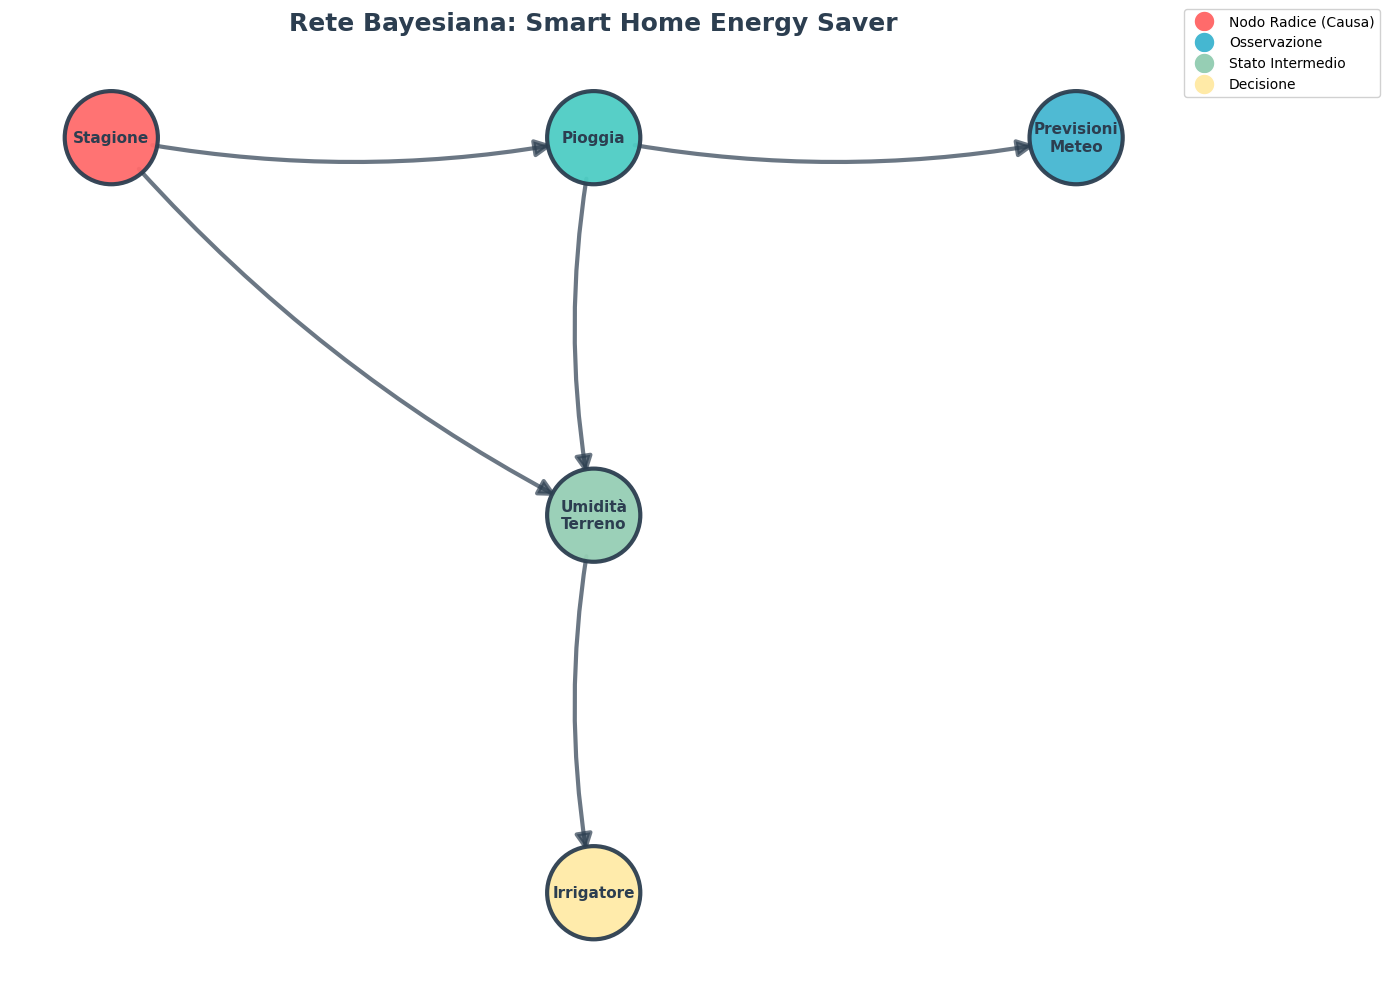

In [51]:
# Visualizzazione della rete bayesiana - Versione migliorata
pos = {
    'Stagione': (0, 2),
    'Pioggia': (1, 2),
    'Previsioni_Meteo': (2, 2),
    'Umidita_Terreno': (1, 1),
    'Irrigatore': (1, 0)
}

plt.figure(figsize=(14, 10))

# Colori per i nodi in base al tipo
node_colors = {
    'Stagione': '#FF6B6B',          # Rosso - nodo radice
    'Pioggia': '#4ECDC4',           # Verde acqua - nodo radice
    'Previsioni_Meteo': '#45B7D1',  # Azzurro - osservazione
    'Umidita_Terreno': '#96CEB4',   # Verde chiaro - stato intermedio
    'Irrigatore': '#FFEAA7'         # Giallo - decisione finale
}

colors = [node_colors[node] for node in bn_model.nodes()]

# Disegna gli archi con stile curvo
nx.draw_networkx_edges(
    bn_model, pos, 
    width=3, 
    alpha=0.7, 
    edge_color='#2C3E50',
    arrowsize=25,
    arrowstyle='-|>',
    connectionstyle='arc3,rad=0.1',
    min_source_margin=30,
    min_target_margin=30
)

# Disegna i nodi con bordo e ombra
nx.draw_networkx_nodes(
    bn_model, pos, 
    node_size=4500, 
    node_color=colors,
    edgecolors='#2C3E50',
    linewidths=3,
    alpha=0.95
)

# Etichette 
labels = {
    'Stagione': 'Stagione',
    'Pioggia': 'Pioggia',
    'Previsioni_Meteo': 'Previsioni\nMeteo',
    'Umidita_Terreno': 'Umidità\nTerreno',
    'Irrigatore': 'Irrigatore'
}

nx.draw_networkx_labels(
    bn_model, pos, 
    labels=labels,
    font_size=11, 
    font_weight='bold',
    font_color='#2C3E50'
)

# Titolo della rete
plt.title("Rete Bayesiana: Smart Home Energy Saver", 
          fontsize=18, fontweight='bold', color='#2C3E50', pad=20)

# Legenda
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF6B6B', markersize=15, label='Nodo Radice (Causa)'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#45B7D1', markersize=15, label='Osservazione'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#96CEB4', markersize=15, label='Stato Intermedio'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFEAA7', markersize=15, label='Decisione')
]
plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1.0, 0.95), fontsize=10, framealpha=0.9)

plt.axis('off')
plt.tight_layout()
plt.show()


### Verifica della Validità del Modello

La cella successiva esegue un controllo di validità sulla rete bayesiana costruita. Questo passaggio è fondamentale per assicurarsi che:

- **Tutte le CPT siano correttamente definite**: Ogni distribuzione di probabilità condizionata deve essere valida
- **Le probabilità sommino a 1**: Per ogni combinazione di valori delle variabili genitori, le probabilità degli stati figli devono sommare esattamente a 1
- **La struttura sia coerente**: Gli archi e le dipendenze devono essere consistenti con le CPT fornite

Se il modello risulta **valido**, si può procedere con l'inferenza probabilistica; altrimenti, è necessario rivedere le definizioni delle CPT.

In [60]:
# Verifica della validità del modello
is_valid = bn_model.check_model()
print(f"Modello valido: {is_valid}")

if is_valid:
    print("\nTutte le CPT sono corrette e le probabilità sommano a 1!")
else:
    print("\nErrore: alcune CPT non sono valide. Controlla i valori.")


Modello valido: True

Tutte le CPT sono corrette e le probabilità sommano a 1!


### Inferenza sulla Rete Bayesiana

Nella cella successiva viene utilizzato l'algoritmo **Variable Elimination** per eseguire inferenze probabilistiche sulla rete bayesiana. Questo metodo permette di calcolare la distribuzione di probabilità di una variabile dato un insieme di evidenze osservate.

Le query eseguite dimostrano diversi tipi di ragionamento probabilistico:

1. **Query marginale**: Probabilità dell'irrigatore senza alcuna evidenza
2. **Ragionamento causale**: Come la stagione influenza l'irrigatore
3. **Propagazione dell'evidenza**: Effetto della pioggia sull'irrigatore
4. **Query con evidenze multiple**: Combinazione di stagione e previsioni meteo
5. **Inferenza su nodi intermedi**: Probabilità dell'umidità del terreno date le condizioni meteorologiche

In [53]:
from pgmpy.inference import VariableElimination

# Creazione dell'oggetto per l'inferenza usando Variable Elimination
inference = VariableElimination(bn_model)

# Query 1: Probabilità che l'irrigatore sia acceso, senza evidenze
print("=== Query 1: P(Irrigatore) senza evidenze ===")
result1 = inference.query(variables=['Irrigatore'])
print(result1)

# Query 2: Probabilità che l'irrigatore sia acceso, per ogni stagione
print("\n=== Query 2: P(Irrigatore | Stagione) - Per tutte le stagioni ===")
stagioni = ['Inverno', 'Primavera', 'Estate', 'Autunno']
results_stagioni = {}
for stagione in stagioni:
    result = inference.query(variables=['Irrigatore'], evidence={'Stagione': stagione})
    results_stagioni[stagione] = result
    print(f"\nStagione: {stagione}")
    print(result)

# Query 3: Probabilità che l'irrigatore sia acceso, dato che piove
print("\n=== Query 3: P(Irrigatore | Pioggia=Sì) ===")
result3 = inference.query(variables=['Irrigatore'], evidence={'Pioggia': 'Sì'})
print(result3)

# Query 4: Probabilità che l'irrigatore sia acceso, per ogni stagione con previsioni di sole
print("\n=== Query 4: P(Irrigatore | Stagione, Previsioni_Meteo=Sole) - Per tutte le stagioni ===")
results_sole = {}
for stagione in stagioni:
    result = inference.query(variables=['Irrigatore'], evidence={'Stagione': stagione, 'Previsioni_Meteo': 'Sole'})
    results_sole[stagione] = result
    print(f"\nStagione: {stagione}, Previsioni: Sole")
    print(result)

# Query 5: Probabilità dell'umidità del terreno per ogni stagione con pioggia
print("\n=== Query 5: P(Umidita_Terreno | Stagione, Pioggia=Sì) - Per tutte le stagioni ===")
results_umidita = {}
for stagione in stagioni:
    result = inference.query(variables=['Umidita_Terreno'], evidence={'Stagione': stagione, 'Pioggia': 'Sì'})
    results_umidita[stagione] = result
    print(f"\nStagione: {stagione}, Pioggia: Sì")
    print(result)

=== Query 1: P(Irrigatore) senza evidenze ===
+--------------------+-------------------+
| Irrigatore         |   phi(Irrigatore) |
+====================+===================+
| Irrigatore(Spento) |            0.6240 |
+--------------------+-------------------+
| Irrigatore(Acceso) |            0.3760 |
+--------------------+-------------------+

=== Query 2: P(Irrigatore | Stagione) - Per tutte le stagioni ===

Stagione: Inverno
+--------------------+-------------------+
| Irrigatore         |   phi(Irrigatore) |
+====================+===================+
| Irrigatore(Spento) |            0.8296 |
+--------------------+-------------------+
| Irrigatore(Acceso) |            0.1704 |
+--------------------+-------------------+

Stagione: Primavera
+--------------------+-------------------+
| Irrigatore         |   phi(Irrigatore) |
+====================+===================+
| Irrigatore(Spento) |            0.7352 |
+--------------------+-------------------+
| Irrigatore(Acceso) |        

### Tipi di Ragionamento nelle Reti Bayesiane

La rete bayesiana permette di eseguire diversi tipi di ragionamento probabilistico:

1. **Predizione Causale (Top-Down)**: Ragionamento dalle cause agli effetti
    - Esempio: Data la stagione, qual è la probabilità che l'irrigatore si accenda?
    - Direzione: Nodi radice -> Nodi foglia

2. **Diagnosi Evidenziale (Bottom-Up)**: Ragionamento dagli effetti alle cause
    - Esempio: L'irrigatore è spento, qual è la probabilità che abbia piovuto?
    - Direzione: Nodi foglia -> Nodi radice

3. **Explaining Away (Ragionamento Intercausale)**: Quando osserviamo un effetto e scopriamo una delle cause, la probabilità dell'altra causa cambia
    - Esempio: Se il terreno è umido e scopriamo che è Estate, la pioggia diventa più probabile (perché l'Estate da sola non spiega l'umidità)

Le celle successive dimostrano ciascuno di questi tipi di ragionamento con query specifiche sulla rete.

In [54]:
# Predizione Causale: P(Irrigatore | Stagione=Inverno)
# Direzione: dall'alto (causa) verso il basso (effetto)
print("=== Predizione Causale ===")
print("Siamo in Inverno. Qual è la probabilità che l'irrigatore si accenda?\n")

result_causale = inference.query(variables=['Irrigatore'], evidence={'Stagione': 'Inverno'})
print(result_causale)

=== Predizione Causale ===
Siamo in Inverno. Qual è la probabilità che l'irrigatore si accenda?

+--------------------+-------------------+
| Irrigatore         |   phi(Irrigatore) |
+====================+===================+
| Irrigatore(Spento) |            0.8296 |
+--------------------+-------------------+
| Irrigatore(Acceso) |            0.1704 |
+--------------------+-------------------+



### Predizione Causale (Top-Down)

La **predizione causale** è un tipo di ragionamento che procede dalle cause agli effetti, seguendo la direzione naturale degli archi nella rete bayesiana.

In questo esempio:
- **Causa osservata**: Stagione = Inverno (nodo radice)
- **Effetto calcolato**: Probabilità che l'irrigatore si accenda (nodo foglia)

Il ragionamento causale propaga l'informazione attraverso la catena:
`Stagione → Pioggia → Umidità Terreno → Irrigatore`

**Interpretazione del risultato**:
- In Inverno è più probabile che piova (80% vs 15% in Estate, 60% in Primavera, 65% in Autunno)
- La pioggia aumenta significativamente l'umidità del terreno
- Se il terreno è umido, l'irrigatore ha meno probabilità di accendersi (10% di probabilità di accensione vs 90% se il terreno è secco)
- In Estate il terreno tende a restare secco, quindi l'irrigatore si accenderà più frequentemente

Questo tipo di inferenza risponde a domande del tipo: "Cosa succederà se...?"


In [55]:
# Diagnosi Evidenziale: ragionamento dal basso (effetto) verso l'alto (causa)
# L'irrigatore è spento e le previsioni davano sole. Qual è la probabilità che abbia piovuto?
print("=== Diagnosi Evidenziale ===")
print("L'irrigatore è spento e le previsioni davano Sole.")
print("Qual è la probabilità che in realtà abbia piovuto?\n")

# P(Pioggia | Irrigatore=Spento, Previsioni_Meteo=Sole)
result_diagnosi_pioggia = inference.query(
    variables=['Pioggia'], 
    evidence={'Irrigatore': 'Spento', 'Previsioni_Meteo': 'Sole'}
)
print("P(Pioggia | Irrigatore=Spento, Previsioni_Meteo=Sole):")
print(result_diagnosi_pioggia)

# P(Umidita_Terreno | Irrigatore=Spento, Previsioni_Meteo=Sole)
# Questo può indicare se il sensore di umidità rileva umido (possibile malfunzionamento se non ha piovuto)
print("\nP(Umidita_Terreno | Irrigatore=Spento, Previsioni_Meteo=Sole):")
result_diagnosi_umidita = inference.query(
    variables=['Umidita_Terreno'], 
    evidence={'Irrigatore': 'Spento', 'Previsioni_Meteo': 'Sole'}
)
print(result_diagnosi_umidita)

=== Diagnosi Evidenziale ===
L'irrigatore è spento e le previsioni davano Sole.
Qual è la probabilità che in realtà abbia piovuto?

P(Pioggia | Irrigatore=Spento, Previsioni_Meteo=Sole):
+-------------+----------------+
| Pioggia     |   phi(Pioggia) |
+=============+================+
| Pioggia(No) |         0.6851 |
+-------------+----------------+
| Pioggia(Sì) |         0.3149 |
+-------------+----------------+

P(Umidita_Terreno | Irrigatore=Spento, Previsioni_Meteo=Sole):
+------------------------+------------------------+
| Umidita_Terreno        |   phi(Umidita_Terreno) |
+========================+========================+
| Umidita_Terreno(Secco) |                 0.1747 |
+------------------------+------------------------+
| Umidita_Terreno(Umido) |                 0.8253 |
+------------------------+------------------------+


### Diagnosi Evidenziale (Bottom-Up)

La **diagnosi evidenziale** è un tipo di ragionamento che procede dagli effetti alle cause, in direzione opposta agli archi della rete bayesiana.

In questo esempio:
- **Effetti osservati**: Irrigatore = Spento, Previsioni Meteo = Sole (nodi terminali/osservazioni)
- **Cause calcolate**: Probabilità che abbia piovuto e stato dell'umidità del terreno

Il ragionamento diagnostico propaga l'informazione "all'indietro":
`Irrigatore → Umidità Terreno → Pioggia`

**Interpretazione del risultato**:
- Se l'irrigatore è spento, è probabile che il terreno sia umido (altrimenti si sarebbe acceso)
- Le previsioni davano Sole, ma le previsioni possono essere errate (20% di errore)
- La combinazione di queste evidenze ci permette di inferire la probabilità che abbia effettivamente piovuto

Questo tipo di inferenza risponde a domande del tipo: "Cosa può aver causato questo?"

=== Explaining Away (Ragionamento Intercausale) ===

1. P(Pioggia) - Probabilità a priori:
+-------------+----------------+
| Pioggia     |   phi(Pioggia) |
+=============+================+
| Pioggia(No) |         0.4500 |
+-------------+----------------+
| Pioggia(Sì) |         0.5500 |
+-------------+----------------+

2. P(Pioggia | Umidita_Terreno=Umido):
+-------------+----------------+
| Pioggia     |   phi(Pioggia) |
+=============+================+
| Pioggia(No) |         0.1687 |
+-------------+----------------+
| Pioggia(Sì) |         0.8313 |
+-------------+----------------+

3. Probabilità di pioggia (Terreno Umido + Stagione):

Inverno: +-------------+----------------+
| Pioggia     |   phi(Pioggia) |
+=============+================+
| Pioggia(No) |         0.1316 |
+-------------+----------------+
| Pioggia(Sì) |         0.8684 |
+-------------+----------------+
Primavera: +-------------+----------------+
| Pioggia     |   phi(Pioggia) |
+=============+================+
|

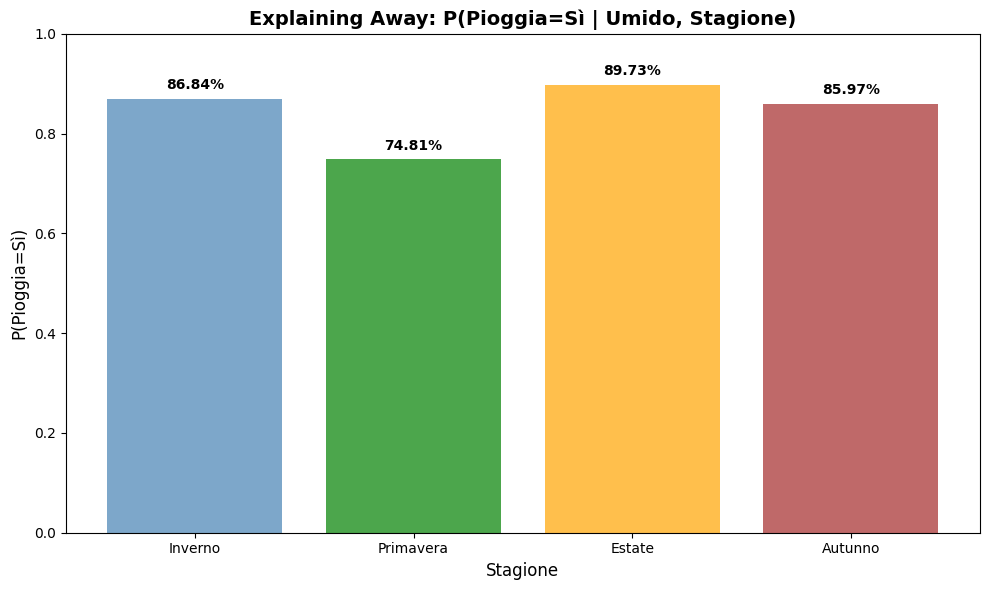


Interpretazione:
• INVERNO (stagione umida): P(Pioggia) BASSA → l'Inverno 'spiega' l'umidità
• ESTATE (stagione secca): P(Pioggia) ALTA → solo la Pioggia spiega l'umidità
• Questo è 'Explaining Away': una causa spiega via l'effetto, riducendo l'altra


In [56]:
# Explaining Away (Ragionamento Intercausale)
print("=== Explaining Away (Ragionamento Intercausale) ===\n")

# Step 1: Probabilità a priori
result_prior = inference.query(variables=['Pioggia'])
print("1. P(Pioggia) - Probabilità a priori:")
print(result_prior)

# Step 2: Terreno umido
result_umido = inference.query(variables=['Pioggia'], evidence={'Umidita_Terreno': 'Umido'})
print("\n2. P(Pioggia | Umidita_Terreno=Umido):")
print(result_umido)

# Step 3: Explaining Away per ogni stagione
print("\n3. Probabilità di pioggia (Terreno Umido + Stagione):\n")
explaining_away_results = {}
for stagione in stagioni:
    result = inference.query(
        variables=['Pioggia'], 
        evidence={'Umidita_Terreno': 'Umido', 'Stagione': stagione}
    )
    explaining_away_results[stagione] = result
    print(f"{stagione}: {result}")

# Step 4: Visualizzazione comparativa
fig, ax = plt.subplots(figsize=(10, 6))
prob_pioggia_si_values = [explaining_away_results[s].values[1] for s in stagioni]
bars = ax.bar(stagioni, prob_pioggia_si_values, color=['steelblue', 'green', 'orange', 'brown'], alpha=0.7)
ax.set_ylabel('P(Pioggia=Sì)', fontsize=12)
ax.set_xlabel('Stagione', fontsize=12)
ax.set_title('Explaining Away: P(Pioggia=Sì | Umido, Stagione)', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)
for bar, val in zip(bars, prob_pioggia_si_values):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.2%}', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretazione:")
print("• INVERNO (stagione umida): P(Pioggia) BASSA → l'Inverno 'spiega' l'umidità")
print("• ESTATE (stagione secca): P(Pioggia) ALTA → solo la Pioggia spiega l'umidità")
print("• Questo è 'Explaining Away': una causa spiega via l'effetto, riducendo l'altra")


### Analisi Decisionale con Teoria dell'Utilità

La cella successiva implementa un semplice modello decisionale basato sulla **teoria dell'utilità attesa**. Questo approccio combina le probabilità inferite dalla rete bayesiana con i costi associati a ciascuna decisione.

**Componenti del modello**:
- **Costo fisso irrigazione**: Costo certo sostenuto se si decide di irrigare (acqua, energia)
- **Costo rischio piante**: Costo atteso se non si irriga e il terreno è secco (danno alle piante)

**Formula decisionale**:
```
Costo Rischio = Costo Danno × P(Terreno Secco | Evidenze)
```

**Regola di decisione**:
- Se il costo atteso del rischio supera il costo dell'irrigazione → **Irrigare**
- Altrimenti → **Non irrigare** (risparmio risorse)

Questo esempio dimostra come le reti bayesiane possano essere integrate in sistemi di supporto alle decisioni per automatizzare scelte ottimali in condizioni di incertezza.

In [57]:
# Esempio di logica decisionale basata sulla probabilità
# Recuperiamo la probabilità che il terreno sia SECCO
q = inference.query(variables=['Umidita_Terreno'], evidence={'Previsioni_Meteo': 'Sole'})
prob_secco = q.values[0] # Assumendo che l'indice 0 sia 'Secco'

# Calcolo utilità
costo_irrigare = 5
costo_rischio_piante = 50 * prob_secco 

print(f"Costo fisso irrigazione: {costo_irrigare}€")
print(f"Costo atteso rischio piante: {costo_rischio_piante:.2f}€")

if costo_rischio_piante > costo_irrigare:
    print("DECISIONE: Conviene accendere l'irrigatore!")
else:
    print("DECISIONE: Risparmia acqua, il rischio è basso.")

Costo fisso irrigazione: 5€
Costo atteso rischio piante: 32.79€
DECISIONE: Conviene accendere l'irrigatore!


### Visualizzazione Riassuntiva dei Risultati

La cella successiva genera una dashboard con 6 grafici che riassumono le analisi effettuate sulla rete bayesiana:

1. **P(Stagione)**: Distribuzione a priori delle 4 stagioni (25% ognuna)
2. **P(Pioggia | Stagione)**: Come le 4 stagioni influenzano la probabilità di pioggia
3. **P(Irrigatore=Acceso | Evidenze)**: Confronto della probabilità di accensione dell'irrigatore con diverse evidenze
4. **Explaining Away**: Dimostrazione del ragionamento intercausale sulla probabilità di pioggia
5. **Diagnosi Evidenziale**: Risultati dell'inferenza diagnostica dato irrigatore spento e previsioni di sole
6. **Analisi Costi**: Confronto tra costo fisso di irrigazione e costo atteso del rischio per le piante

Questa visualizzazione permette di comprendere rapidamente i risultati delle inferenze e supporta la decisione finale sul sistema di irrigazione.

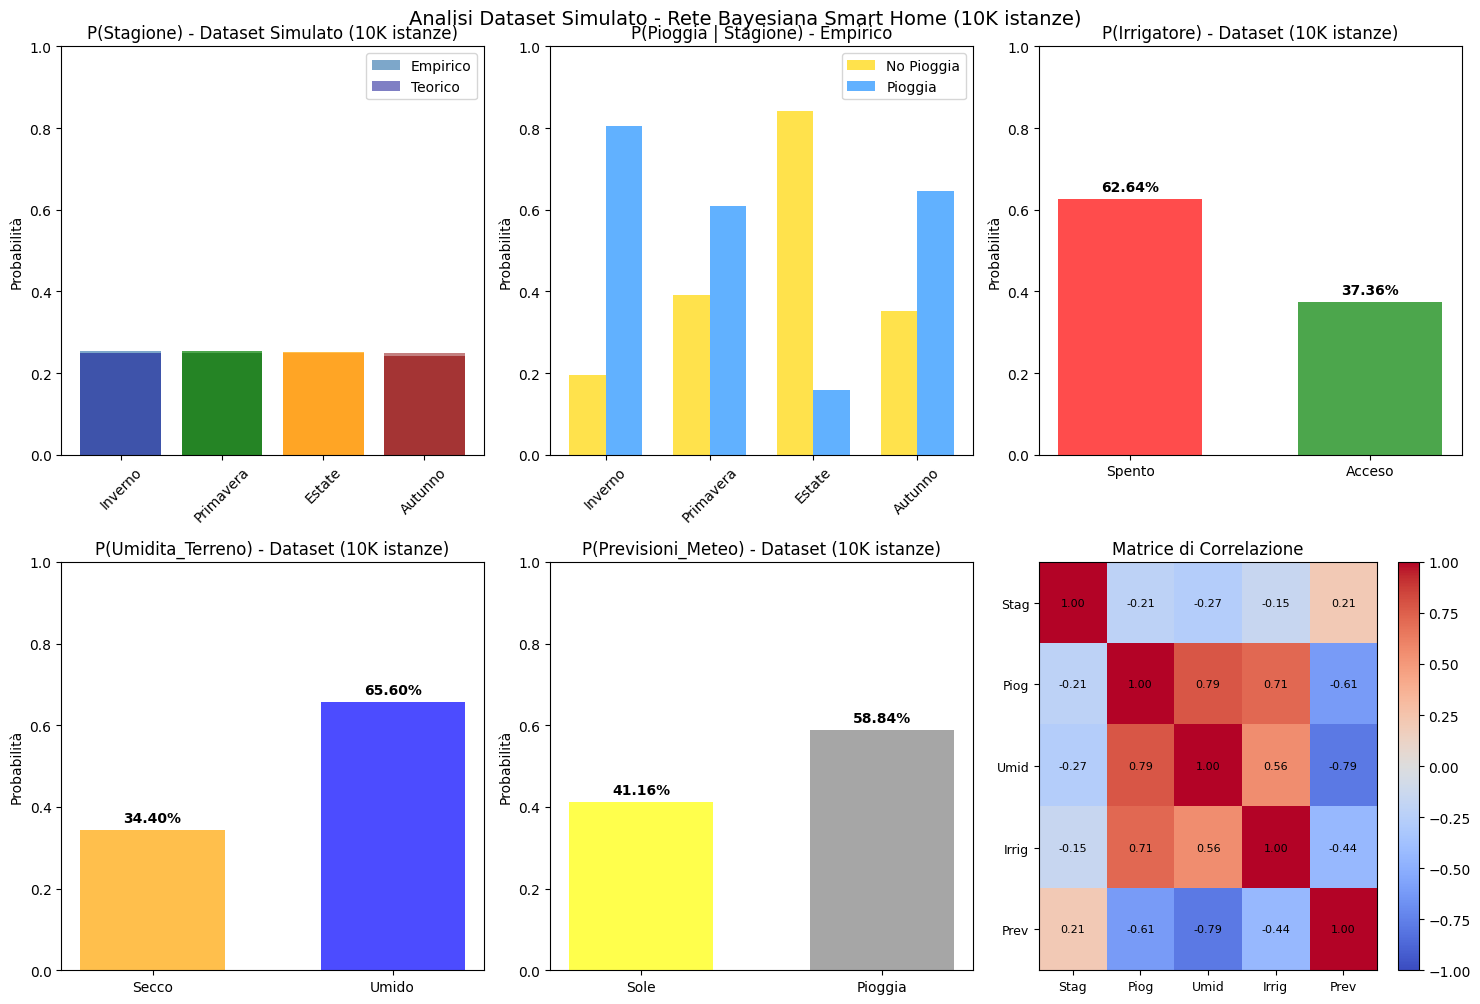


STATISTICHE DATASET SIMULATO (10.000 istanze)
Dimensioni: (10000, 5)

Distribuzione Irrigatore:
  Spento: 62.64%
  Acceso: 37.36%

Matrice di Correlazione Pioggia-Umidità:
Umidita_Terreno   Secco   Umido
Pioggia                        
No               0.3385  0.1066
Sì               0.0055  0.5494
Umidita_Terreno   Secco   Umido
Pioggia                        
No               0.3385  0.1066
Sì               0.0055  0.5494
Umidita_Terreno   Secco   Umido
Pioggia                        
No               0.3385  0.1066
Sì               0.0055  0.5494


In [67]:
# Grafici riassuntivi con DATASET SIMULATO - 10.000 istanze

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Distribuzione Stagione dal Dataset
ax1 = axes[0, 0]
stagione_counts = dataset['Stagione'].value_counts()
stagione_counts = stagione_counts.reindex(['Inverno', 'Primavera', 'Estate', 'Autunno'])
stagione_prob_empirica = stagione_counts / len(dataset)
ax1.bar(['Inverno', 'Primavera', 'Estate', 'Autunno'], stagione_prob_empirica.values, color=['steelblue', 'green', 'orange', 'brown'], alpha=0.7, label='Empirico')
ax1.bar(['Inverno', 'Primavera', 'Estate', 'Autunno'], cpd_stagione.values.flatten(), color=['darkblue', 'darkgreen', 'darkorange', 'darkred'], alpha=0.5, label='Teorico')
ax1.set_title('P(Stagione) - Dataset Simulato (10K istanze)')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylabel('Probabilità')
ax1.set_ylim(0, 1)
ax1.legend()

# 2. Distribuzione Pioggia condizionata a Stagione dal Dataset
ax2 = axes[0, 1]
pioggia_stagione_crosstab = pd.crosstab(dataset['Stagione'], dataset['Pioggia'], normalize='index')
# Riordina le stagioni nell'ordine corretto (il crosstab le ordina alfabeticamente)
pioggia_stagione_crosstab = pioggia_stagione_crosstab.reindex(['Inverno', 'Primavera', 'Estate', 'Autunno'])
x = ['Inverno', 'Primavera', 'Estate', 'Autunno']
pioggia_no_emp = pioggia_stagione_crosstab.loc[:, 'No'].values
pioggia_si_emp = pioggia_stagione_crosstab.loc[:, 'Sì'].values
width = 0.35
x_pos = range(len(x))
ax2.bar([p - width/2 for p in x_pos], pioggia_no_emp, width, label='No Pioggia', color='gold', alpha=0.7)
ax2.bar([p + width/2 for p in x_pos], pioggia_si_emp, width, label='Pioggia', color='dodgerblue', alpha=0.7)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(x, rotation=45)
ax2.set_title('P(Pioggia | Stagione) - Empirico')
ax2.set_ylabel('Probabilità')
ax2.legend()
ax2.set_ylim(0, 1)

# 3. Distribuzione Irrigatore dal Dataset
ax3 = axes[0, 2]
irrigatore_counts = dataset['Irrigatore'].value_counts()
irrigatore_counts = irrigatore_counts.reindex(['Spento', 'Acceso'])
irrigatore_prob = irrigatore_counts / len(dataset)
colors_irr = ['red', 'green']
ax3.bar(['Spento', 'Acceso'], irrigatore_prob.values, color=colors_irr, alpha=0.7, width=0.6)
ax3.set_title('P(Irrigatore) - Dataset (10K istanze)')
ax3.set_ylabel('Probabilità')
ax3.set_ylim(0, 1)
for i, v in enumerate(irrigatore_prob.values):
    ax3.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# 4. Distribuzione Umidità Terreno dal Dataset
ax4 = axes[1, 0]
umidita_counts = dataset['Umidita_Terreno'].value_counts()
umidita_counts = umidita_counts.reindex(['Secco', 'Umido'])
umidita_prob = umidita_counts / len(dataset)
colors_umid = ['orange', 'blue']
ax4.bar(['Secco', 'Umido'], umidita_prob.values, color=colors_umid, alpha=0.7, width=0.6)
ax4.set_title('P(Umidita_Terreno) - Dataset (10K istanze)')
ax4.set_ylabel('Probabilità')
ax4.set_ylim(0, 1)
for i, v in enumerate(umidita_prob.values):
    ax4.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

ax5 = axes[1, 1]
previsioni_counts = dataset['Previsioni_Meteo'].value_counts()
previsioni_counts = previsioni_counts.reindex(['Sole', 'Pioggia'])
previsioni_prob = previsioni_counts / len(dataset)
colors_prev = ['yellow', 'gray']
ax5.bar(['Sole', 'Pioggia'], previsioni_prob.values, color=colors_prev, alpha=0.7, width=0.6)
ax5.set_title('P(Previsioni_Meteo) - Dataset (10K istanze)')
ax5.set_ylabel('Probabilità')
ax5.set_ylim(0, 1)
for i, v in enumerate(previsioni_prob.values):
    ax5.text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

# 6. Matrice di Correlazione (Heatmap semplice)
ax6 = axes[1, 2]
# Converto i dati categorici in numerici per la correlazione
dataset_numeric = dataset.copy()
mappings = {
    'Stagione': {'Inverno': 0, 'Primavera': 1, 'Estate': 2, 'Autunno': 3},
    'Pioggia': {'No': 0, 'Sì': 1},
    'Umidita_Terreno': {'Secco': 0, 'Umido': 1},
    'Irrigatore': {'Spento': 0, 'Acceso': 1},
    'Previsioni_Meteo': {'Sole': 0, 'Pioggia': 1}
}
for col, mapping in mappings.items():
    dataset_numeric[col] = dataset[col].map(mapping)

correlation_matrix = dataset_numeric.corr()
im = ax6.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
ax6.set_xticks(range(len(correlation_matrix.columns)))
ax6.set_yticks(range(len(correlation_matrix.columns)))
ax6.set_xticklabels(['Stag', 'Piog', 'Umid', 'Irrig', 'Prev'], fontsize=9)
ax6.set_yticklabels(['Stag', 'Piog', 'Umid', 'Irrig', 'Prev'], fontsize=9)
ax6.set_title('Matrice di Correlazione')
plt.colorbar(im, ax=ax6)

# Aggiungi valori nella heatmap
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = ax6.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.suptitle('Analisi Dataset Simulato - Rete Bayesiana Smart Home (10K istanze)', fontsize=14, y=1.00)
plt.show()

# Stampa statistiche riassuntive
print("\n" + "="*70)
print("STATISTICHE DATASET SIMULATO (10.000 istanze)")
print("="*70)
print(f"Dimensioni: {dataset.shape}")
print(f"\nDistribuzione Irrigatore:")
print(f"  Spento: {(irrigatore_prob['Spento']*100):.2f}%")
print(f"  Acceso: {(irrigatore_prob['Acceso']*100):.2f}%")
print(f"\nMatrice di Correlazione Pioggia-Umidità:")
print(pioggia_umidita_corr)

print(pioggia_umidita_corr)
print(pioggia_umidita_corr)

## Breve Spiegazione su come interpretare i grafici: ##

  **Grafico 1 (Stagione)**:
- fa vedere quanto spesso escono Inverno ed Estate nel dataset e sopra, mette anche le probabilità "teoriche" della CPT (cpd_stagione) per confrontare se il campionamento sta rispettando il modello.

 
**Grafico 2 (Pioggia | Stagione):**

- mostra, separatamente per Inverno ed Estate, con che probabilità nel dataset trovi Pioggia = Sì o No. In pratica è un modo veloce per controllare che "in inverno piove di più" (se la CPT lo dice).



**Grafico 3 (Irrigatore):**

- è la distribuzione totale di Irrigatore (quante volte è Acceso vs Spento). Le percentuali sopra le barre servono solo a renderlo leggibile al volo. 
  
**Grafico 4 (Umidità Terreno):**

- stessa cosa, ma per Umidita_Terreno (Secco vs Umido) cioé dice "in generale" com'è distribuito lo stato del terreno nel dataset.


**Grafico 5 (Previsioni Meteo):** 
- distribuzione di Previsioni_Meteo (Sole vs Pioggia). Qui si vede quanto spesso le previsioni "dicono pioggia" rispetto a "dicono sole", tenendo conto che nel modello le previsioni possono sbagliare. 

**Grafico 6 (Heatmap correlazioni):**
- prima converte tutte le variabili in 0/1, poi calcola la correlazione tra coppie di variabili e la visualizza come matrice colorata. Serve a capire al volo quali variabili "si muovono insieme" (es. pioggia e terreno umido) e quali vanno in direzione opposta.